## Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import yaml

In [2]:
import torch
from torch.utils.data import DataLoader

In [3]:
from dataset_loader import *
from word_embed import *
from models.attention import *
from models.non_attention import *
from models.addns import *
from train_pred import *

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import warnings
warnings.filterwarnings("ignore")

### Converting XML to Txt

In [5]:
!py process_dataset.py --category laptop --split train
!py process_dataset.py --category laptop --split test

[+] Done


0it [00:00, ?it/s]
3048it [00:00, 836227.01it/s]



[+] Done



0it [00:00, ?it/s]
800it [00:00, 392036.83it/s]


### Converting Txt to pkl

In [6]:
!py text_dataset.py --category laptop

Max Context Len  82
[+] Data Saved
[+] Data Saved


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load Word Embeddings

In [7]:
word2id = get_word_info('laptop')
embed_size = 300
word_embeddings = load_word_embeddings(embed_size, word2id)

100%|█████████████████████████████████████████████████████████████████████| 2196018/2196018 [01:04<00:00, 33995.15it/s]


### Preparing Dataset

In [8]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

train_store_path = config['laptop_train_pkl']
test_store_path = config['laptop_test_pkl']

train_store = joblib.load(train_store_path)
test_store = joblib.load(test_store_path)

train_dataset = TextDataset(train_store)
test_dataset = TextDataset(test_store)


### Classification

In [9]:
# Hyper Parameters
embed_size = 300
batch_size = 128
epochs = 7
hidden_size = 300
output_dims = 3
learning_rate = 0.001
l2_reg_fact = 1e-7
clip = 3
dropout = 0.5
vocab_size = len(word2id)

In [10]:
aspects, contexts, _ , _, _ = train_store

max_aspect_len = aspects.shape[1]
max_context_len = contexts.shape[1]

In [11]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = len(test_dataset), shuffle = False)

#### Attention Model

In [12]:
attention_model = AttentionModel(embed_size, vocab_size, word_embeddings,
                                hidden_size, l2_reg_fact, max_aspect_len, max_context_len, output_dims)

In [13]:
attn_model_trainer = Trainer(attention_model, train_loader, test_loader, learning_rate, l2_reg_fact, epochs, clip)

In [14]:
train_losses, val_losses, train_accs, val_accs = attn_model_trainer.train_and_get_losses()

For epoch ==>  1
Train Loss ==> 0.9955385233226576 || Val Loss ==> 0.9750877022743225
Train Acc ==> 0.5293859638665853 || Val Acc ==> 0.6033699154853821

For epoch ==>  2
Train Loss ==> 0.8650111430569699 || Val Loss ==> 0.8590234518051147
Train Acc ==> 0.6495888157894738 || Val Acc ==> 0.6096394896507263

For epoch ==>  3
Train Loss ==> 0.7705637247938859 || Val Loss ==> 0.8361131548881531
Train Acc ==> 0.7119517533402696 || Val Acc ==> 0.6394200563430786

For epoch ==>  4
Train Loss ==> 0.6919099468933908 || Val Loss ==> 0.8562201857566833
Train Acc ==> 0.7621162270244802 || Val Acc ==> 0.6409874796867371

For epoch ==>  5
Train Loss ==> 0.6461681754965531 || Val Loss ==> 0.7638375163078308
Train Acc ==> 0.7984375000000002 || Val Acc ==> 0.7021159768104553

For epoch ==>  6
Train Loss ==> 0.5980438056745028 || Val Loss ==> 0.7997718453407288
Train Acc ==> 0.8173519736842108 || Val Acc ==> 0.672335410118103

For epoch ==>  7
Train Loss ==> 0.5752388442817488 || Val Loss ==> 0.77671122

##### Loss Plots

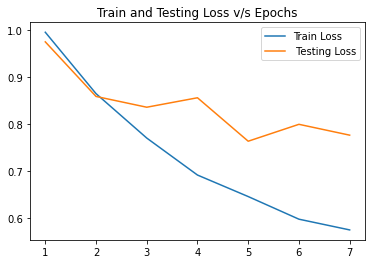

In [15]:
epoch_range = [i for i in range(1, epochs+1)]
plt.figure()
plt.plot(epoch_range, train_losses, label = 'Train Loss')
plt.plot(epoch_range, val_losses, label =' Testing Loss')
plt.title("Train and Testing Loss v/s Epochs")
plt.legend()
plt.show()

##### Accuracy Plots

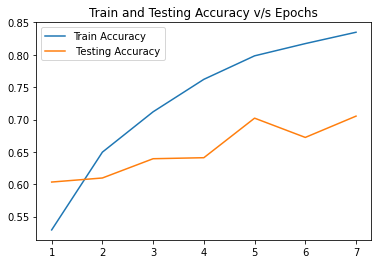

In [16]:
epoch_range = [i for i in range(1, epochs+1)]
plt.figure()
plt.plot(epoch_range, train_accs, label = 'Train Accuracy')
plt.plot(epoch_range, val_accs, label =' Testing Accuracy')
plt.title("Train and Testing Accuracy v/s Epochs")
plt.legend()
plt.show()

##### Save Model

In [17]:
torch.save(attention_model, './model_state/laptop_attn.pth')

##### Load Model

In [18]:
attention_model = torch.load('./model_state/laptop_attn.pth')

##### Visualizing attention

In [61]:
import nltk
from nltk.tokenize import word_tokenize

aspects, contexts, labels, len_aspects, len_contexts = train_store

vis_aspect, vis_context, vis_label, vis_len_aspect, vis_len_context = aspects[60:65], contexts[60:65], labels[60:65], len_aspects[60:65], len_contexts[60:65]

vis_file = config['laptop_train_dataset_txt']
vis_test_file = open(vis_file, 'r')

vis_lines = vis_test_file.readlines()
lines_read = 0

vis_aspect_real= []
vis_context_real = []

for i in range(180, len(vis_lines), 3):
    context = vis_lines[i]
    aspect = vis_lines[i+1]
    
    vis_aspect_real.append(word_tokenize(aspect))
    vis_context_real.append(word_tokenize(context))
    
    lines_read += 1
    
    if lines_read == 5:
        break
print(len(vis_context_real[0]))
print(vis_context[0])

vis_data = (vis_aspect, vis_context, vis_label, vis_len_aspect, vis_len_context)
temp_dataset = TextDataset(vis_data)
temp_data_loader = DataLoader(dataset = temp_dataset, batch_size = 5, shuffle = False)

attention_model.set_attn_store(True)
device = torch.device('cpu')

attention_model.eval()
with torch.no_grad():
    for data in temp_data_loader:
        asp, con, lab, asp_mask, con_mask = data
        asp = asp.to(device)
        con = con.to(device)
        lab = lab.to(device)
        asp_mask = asp_mask.to(device)
        con_mask = con_mask.to(device)

        store = (asp, con, asp_mask, con_mask)
        attention_model(store)

con_attn = attention_model.stored_context_attn.clone()
asp_attn = attention_model.stored_aspect_attn.clone()


con_attn = con_attn.numpy()
asp_attn = asp_attn.numpy()

con_attn_store = []
asp_attn_store = []

for i in range(0, len(con_attn)):
    con_attn_temp = con_attn[i]
    con_attn_temp = con_attn_temp[0:len(vis_context_real[i])]
    con_attn_store.append(con_attn_temp.tolist())


for i in range(0, len(asp_attn)):
    asp_attn_temp = asp_attn[i]
    asp_attn_temp = asp_attn_temp/len(asp_attn_temp)
    asp_attn_temp = asp_attn_temp[0:len(vis_aspect_real[i])]
    asp_attn_store.append(asp_attn_temp.tolist())
    
    
for i in range(0, len(vis_context_real)):
    real_op = []
    attn_op = []
    for item in vis_context_real[i]:
        if type(item) == list:
            real_op.extend(item)
        else:
            real_op.append(item)
            
    for item in con_attn_store[i]:
        if type(item) == list:
            attn_op.extend(item)
        else:
            attn_op.append(item)
    vis_context_real[i] = real_op
    con_attn_store[i] = attn_op


10
[1465  155  180   16  429   12  336  695  106    2    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


0.030721908435225487


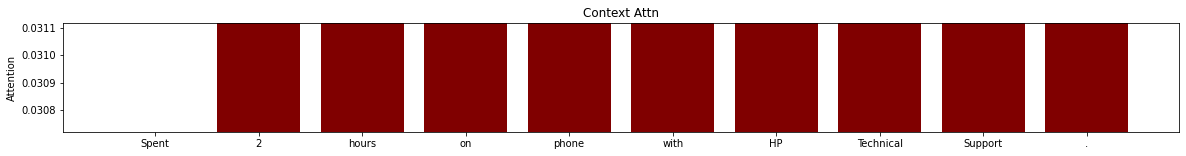

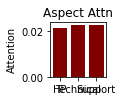

0.016544552519917488


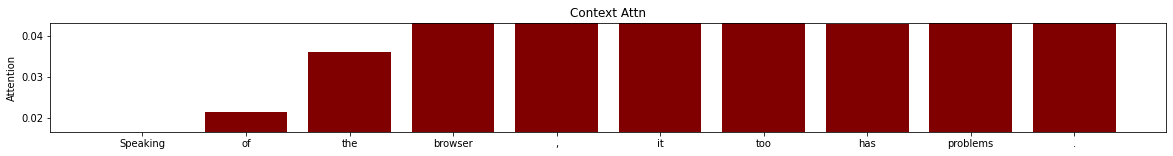

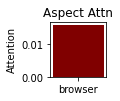

0.011610575020313263


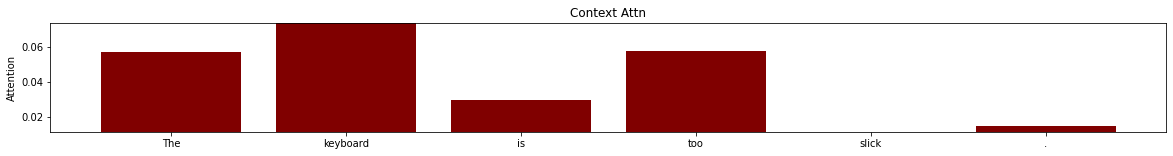

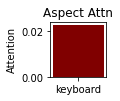

0.03488217666745186


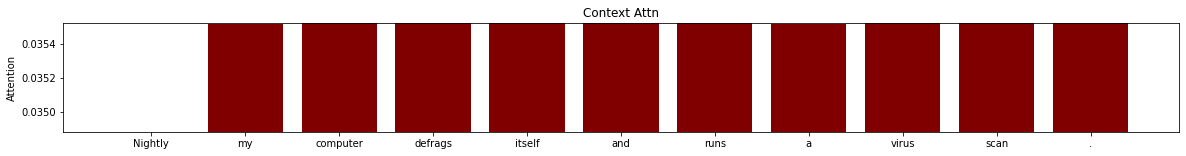

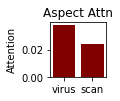

0.012342117726802826


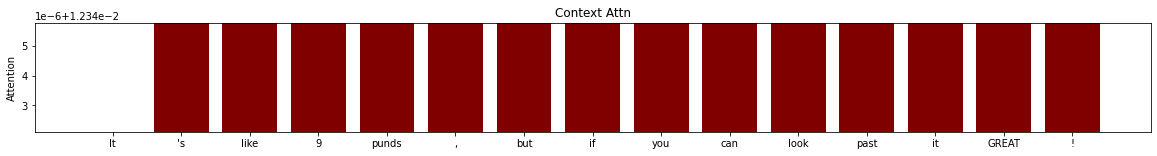

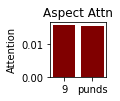

In [62]:
for i in range(0, 5):
    plt.figure(figsize = (20, 2))
    plt.bar(vis_context_real[i], con_attn_store[i], color = 'maroon')
    plt.ylabel('Attention')
    bot = min(con_attn_store[i])
    print(bot)
    top = max(con_attn_store[i])
    plt.ylim(bot,top)
    plt.title('Context Attn')
    plt.show()
    
    plt.figure(figsize = (1, 1))
    plt.bar(vis_aspect_real[i], asp_attn_store[i], color = 'maroon')
    plt.ylabel('Attention')
    plt.title('Aspect Attn')
    plt.show()
    
    

#### Non-Attention Model

In [21]:
non_attention_model = NonAttentionModel(embed_size, vocab_size, word_embeddings,
                                hidden_size, l2_reg_fact, max_aspect_len, max_context_len, output_dims)

In [22]:
non_attn_model_trainer = Trainer(non_attention_model, train_loader, test_loader, learning_rate/10, l2_reg_fact, epochs, clip)

In [23]:
train_losses, val_losses, train_accs, val_accs = non_attn_model_trainer.train_and_get_losses()

For epoch ==>  1
Train Loss ==> 1.0860082852213007 || Val Loss ==> 1.081633448600769
Train Acc ==> 0.4692160082490822 || Val Acc ==> 0.5688871383666992

For epoch ==>  2
Train Loss ==> 1.060628847071999 || Val Loss ==> 1.0716826915740967
Train Acc ==> 0.466063597014076 || Val Acc ==> 0.5641849279403687

For epoch ==>  3
Train Loss ==> 1.0432904864612378 || Val Loss ==> 1.0673655271530151
Train Acc ==> 0.4995065789473686 || Val Acc ==> 0.5735893487930298

For epoch ==>  4
Train Loss ==> 1.0257831906017505 || Val Loss ==> 1.024320125579834
Train Acc ==> 0.5089638157894738 || Val Acc ==> 0.5735893487930298

For epoch ==>  5
Train Loss ==> 0.9338630908413937 || Val Loss ==> 0.9059937000274658
Train Acc ==> 0.606551536133415 || Val Acc ==> 0.6065047025680542

For epoch ==>  6
Train Loss ==> 0.8780763431599266 || Val Loss ==> 0.9087221026420593
Train Acc ==> 0.6497258782386781 || Val Acc ==> 0.5673197746276856

For epoch ==>  7
Train Loss ==> 0.8417315388980665 || Val Loss ==> 0.880164384841

##### Loss Plots

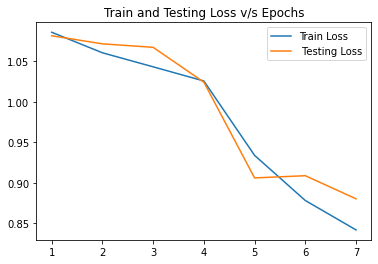

In [24]:
epoch_range = [i for i in range(1, epochs+1)]
plt.figure()
plt.plot(epoch_range, train_losses, label = 'Train Loss')
plt.plot(epoch_range, val_losses, label =' Testing Loss')
plt.title("Train and Testing Loss v/s Epochs")
plt.legend()
plt.show()

##### Accuracy Plots

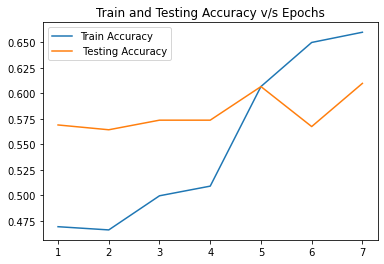

In [25]:
epoch_range = [i for i in range(1, epochs+1)]
plt.figure()
plt.plot(epoch_range, train_accs, label = 'Train Accuracy')
plt.plot(epoch_range, val_accs, label =' Testing Accuracy')
plt.title("Train and Testing Accuracy v/s Epochs")
plt.legend()
plt.show()

##### Save Model

In [26]:
torch.save(non_attention_model, './model_state/laptop_non_attn.pth')